In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, precision_score, f1_score

In [3]:
df = pd.read_csv('creditcard.csv')

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float

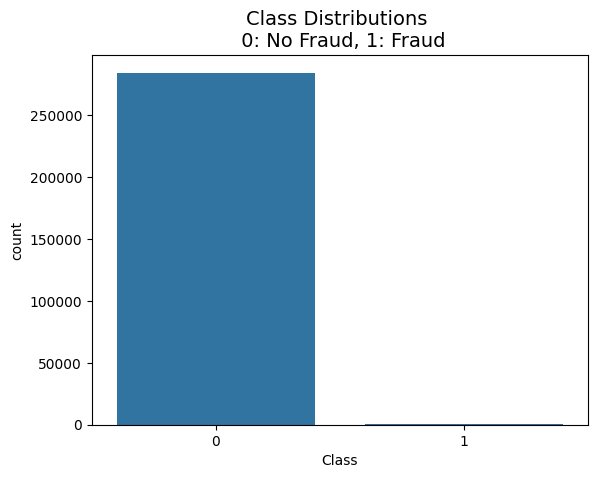

In [4]:
nan_count = df.isna().sum()
print(nan_count)
print('-'*50)
df.info()
# Calculate percentage of each class
no_frauds_percentage = round(df['Class'].value_counts().iloc[0]/len(df) * 100, 2)
frauds_percentage = round(df['Class'].value_counts().iloc[1]/len(df) * 100, 2)
print('-'*50)
print('No Frauds', no_frauds_percentage, '% of the dataset',)
print('Frauds', frauds_percentage, '% of the dataset')
print('Number of frauds:',df['Class'].value_counts().iloc[1])

sns.countplot(x='Class', data=df)
plt.title('Class Distributions \n 0: No Fraud, 1: Fraud', fontsize=14)
plt.show()


In [94]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
unique_counts = df.nunique()
unique_counts

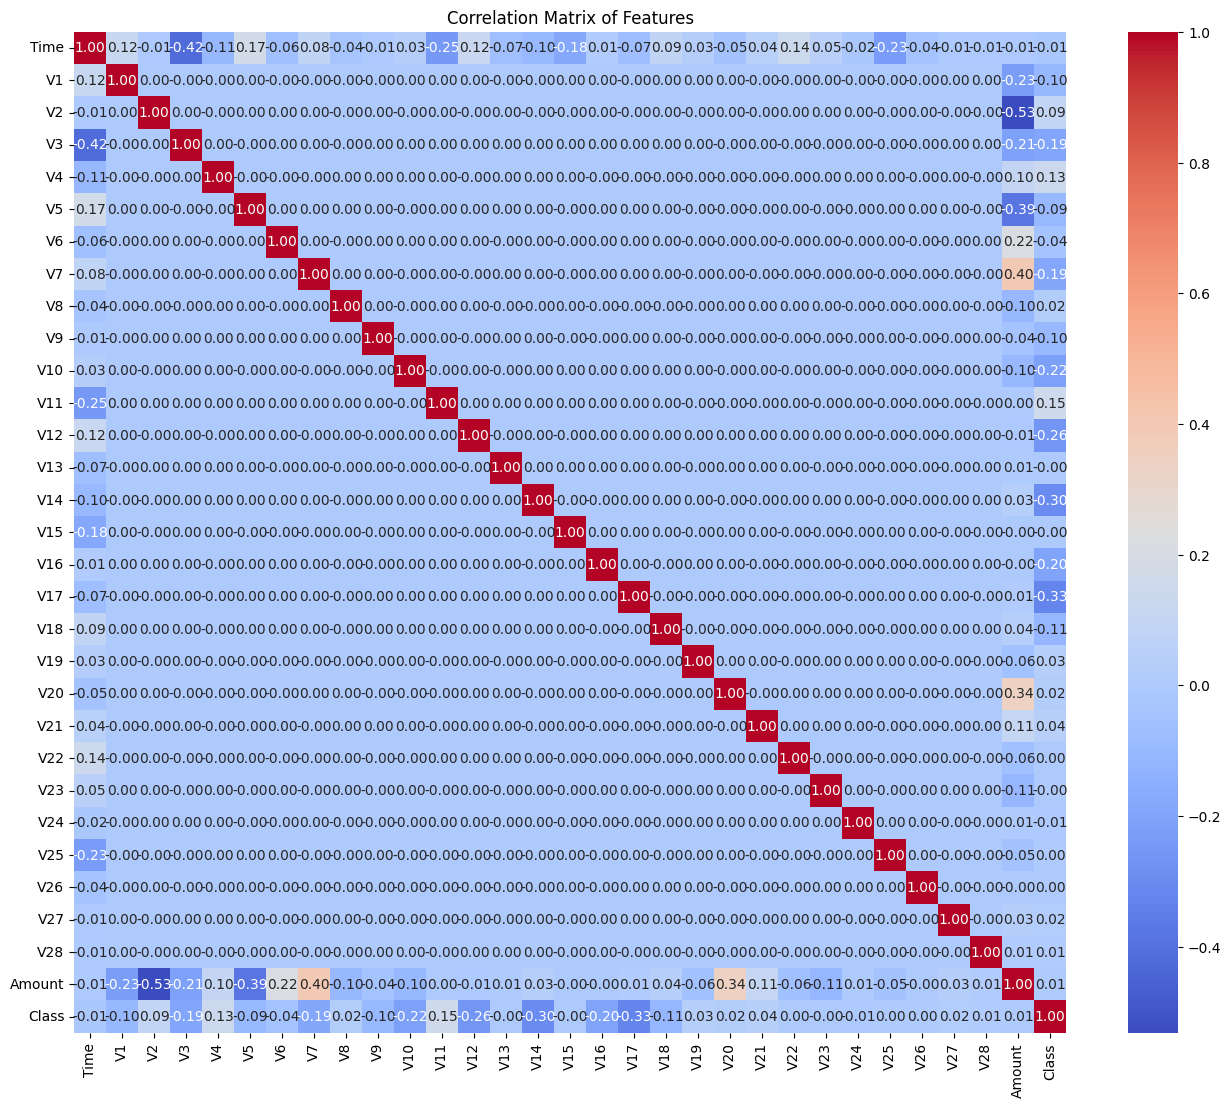

In [95]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(16, 13))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

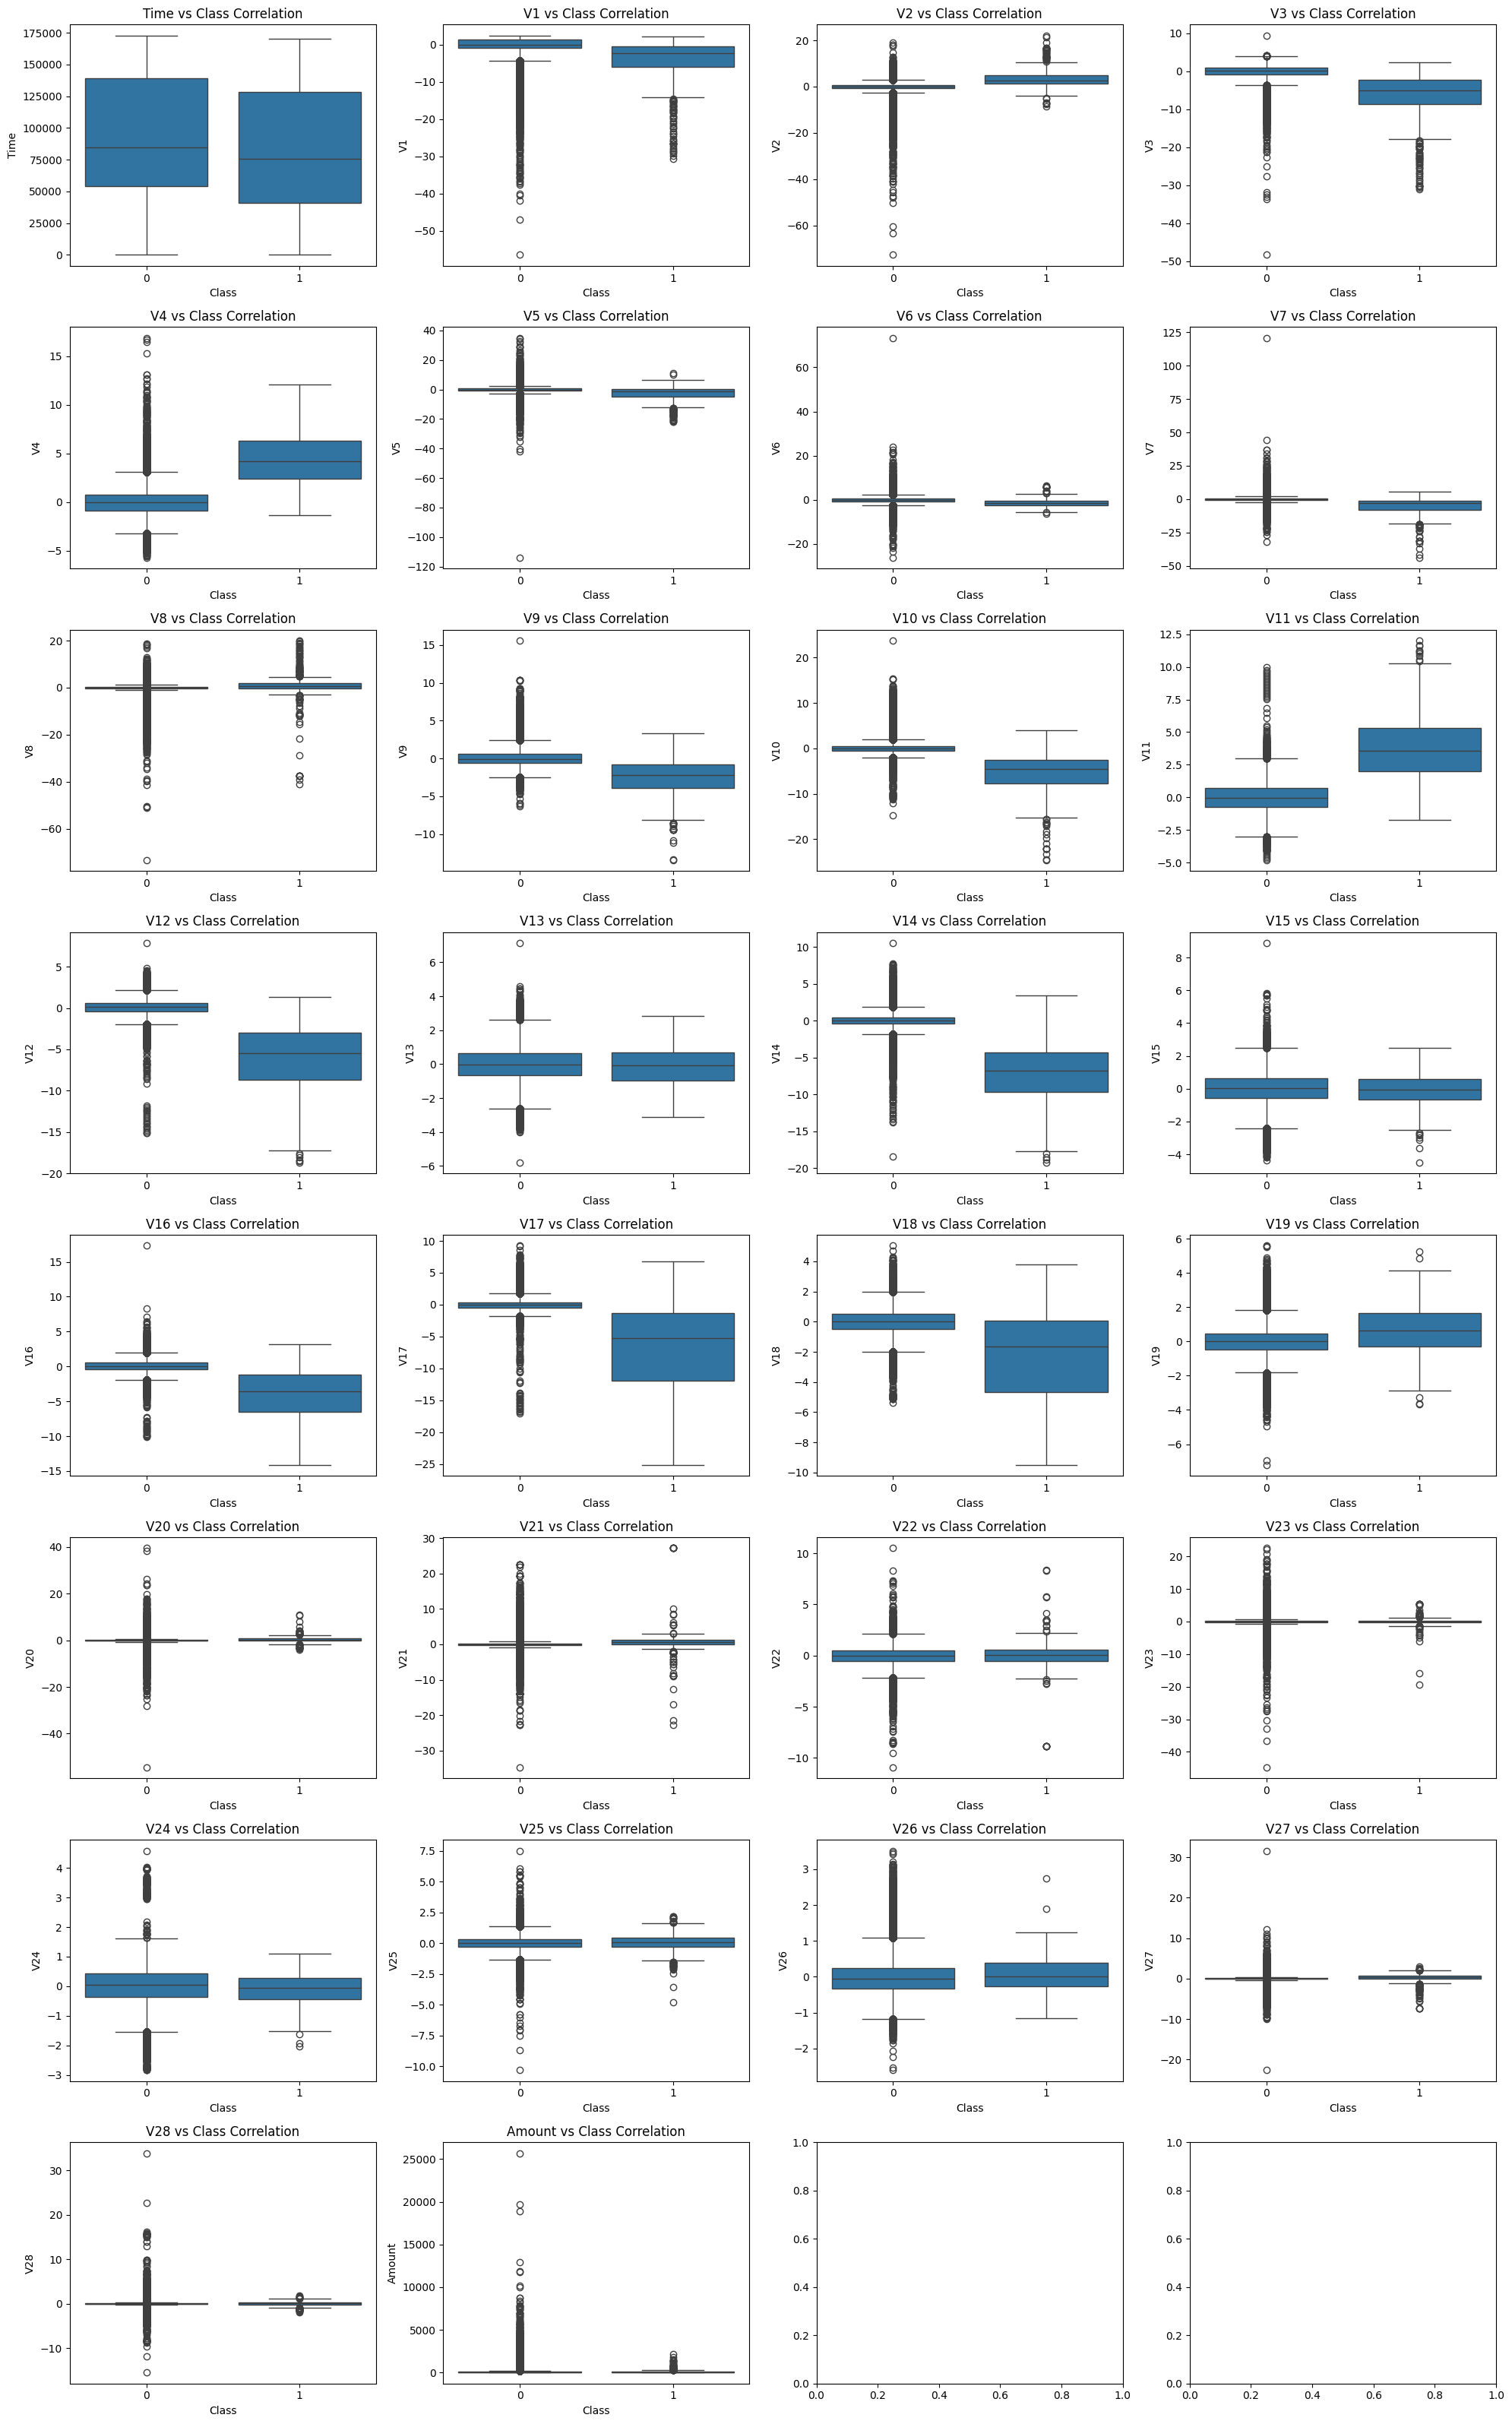

In [96]:
columns = df.drop('Class', axis=1).columns 

num_cols = len(columns)
n_cols_per_row = 4
n_rows = (num_cols + n_cols_per_row - 1) // n_cols_per_row  # Calculate the required number of rows

# Create a figure with subplots
f, axes = plt.subplots(nrows=n_rows, ncols=n_cols_per_row, figsize=(20, n_rows * 4))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Create boxplots
for i, col in enumerate(columns):
    sns.boxplot(x="Class", y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs Class Correlation')

plt.tight_layout()
plt.show()


In [52]:
outlier_counts = {}

# Calculate IQR for each numerical column and count outliers
for column in df.select_dtypes(include=['number']).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    x= 1.5
    outliers = df[(df[column] < (Q1 - x * IQR)) | (df[column] > (Q3 + x * IQR))]
    outlier_counts[column] = outliers.shape[0]

# Display the number of outliers in each column
print("Number of Outliers in Each Column:")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")


Number of Outliers in Each Column:
Time: 0
V1: 7062
V2: 13526
V3: 3363
V4: 11148
V5: 12295
V6: 22965
V7: 8948
V8: 24134
V9: 8283
V10: 9496
V11: 780
V12: 15348
V13: 3368
V14: 14149
V15: 2894
V16: 8184
V17: 7420
V18: 7533
V19: 10205
V20: 27770
V21: 14497
V22: 1317
V23: 18541
V24: 4774
V25: 5367
V26: 5596
V27: 39163
V28: 30342
Amount: 31904
Class: 492


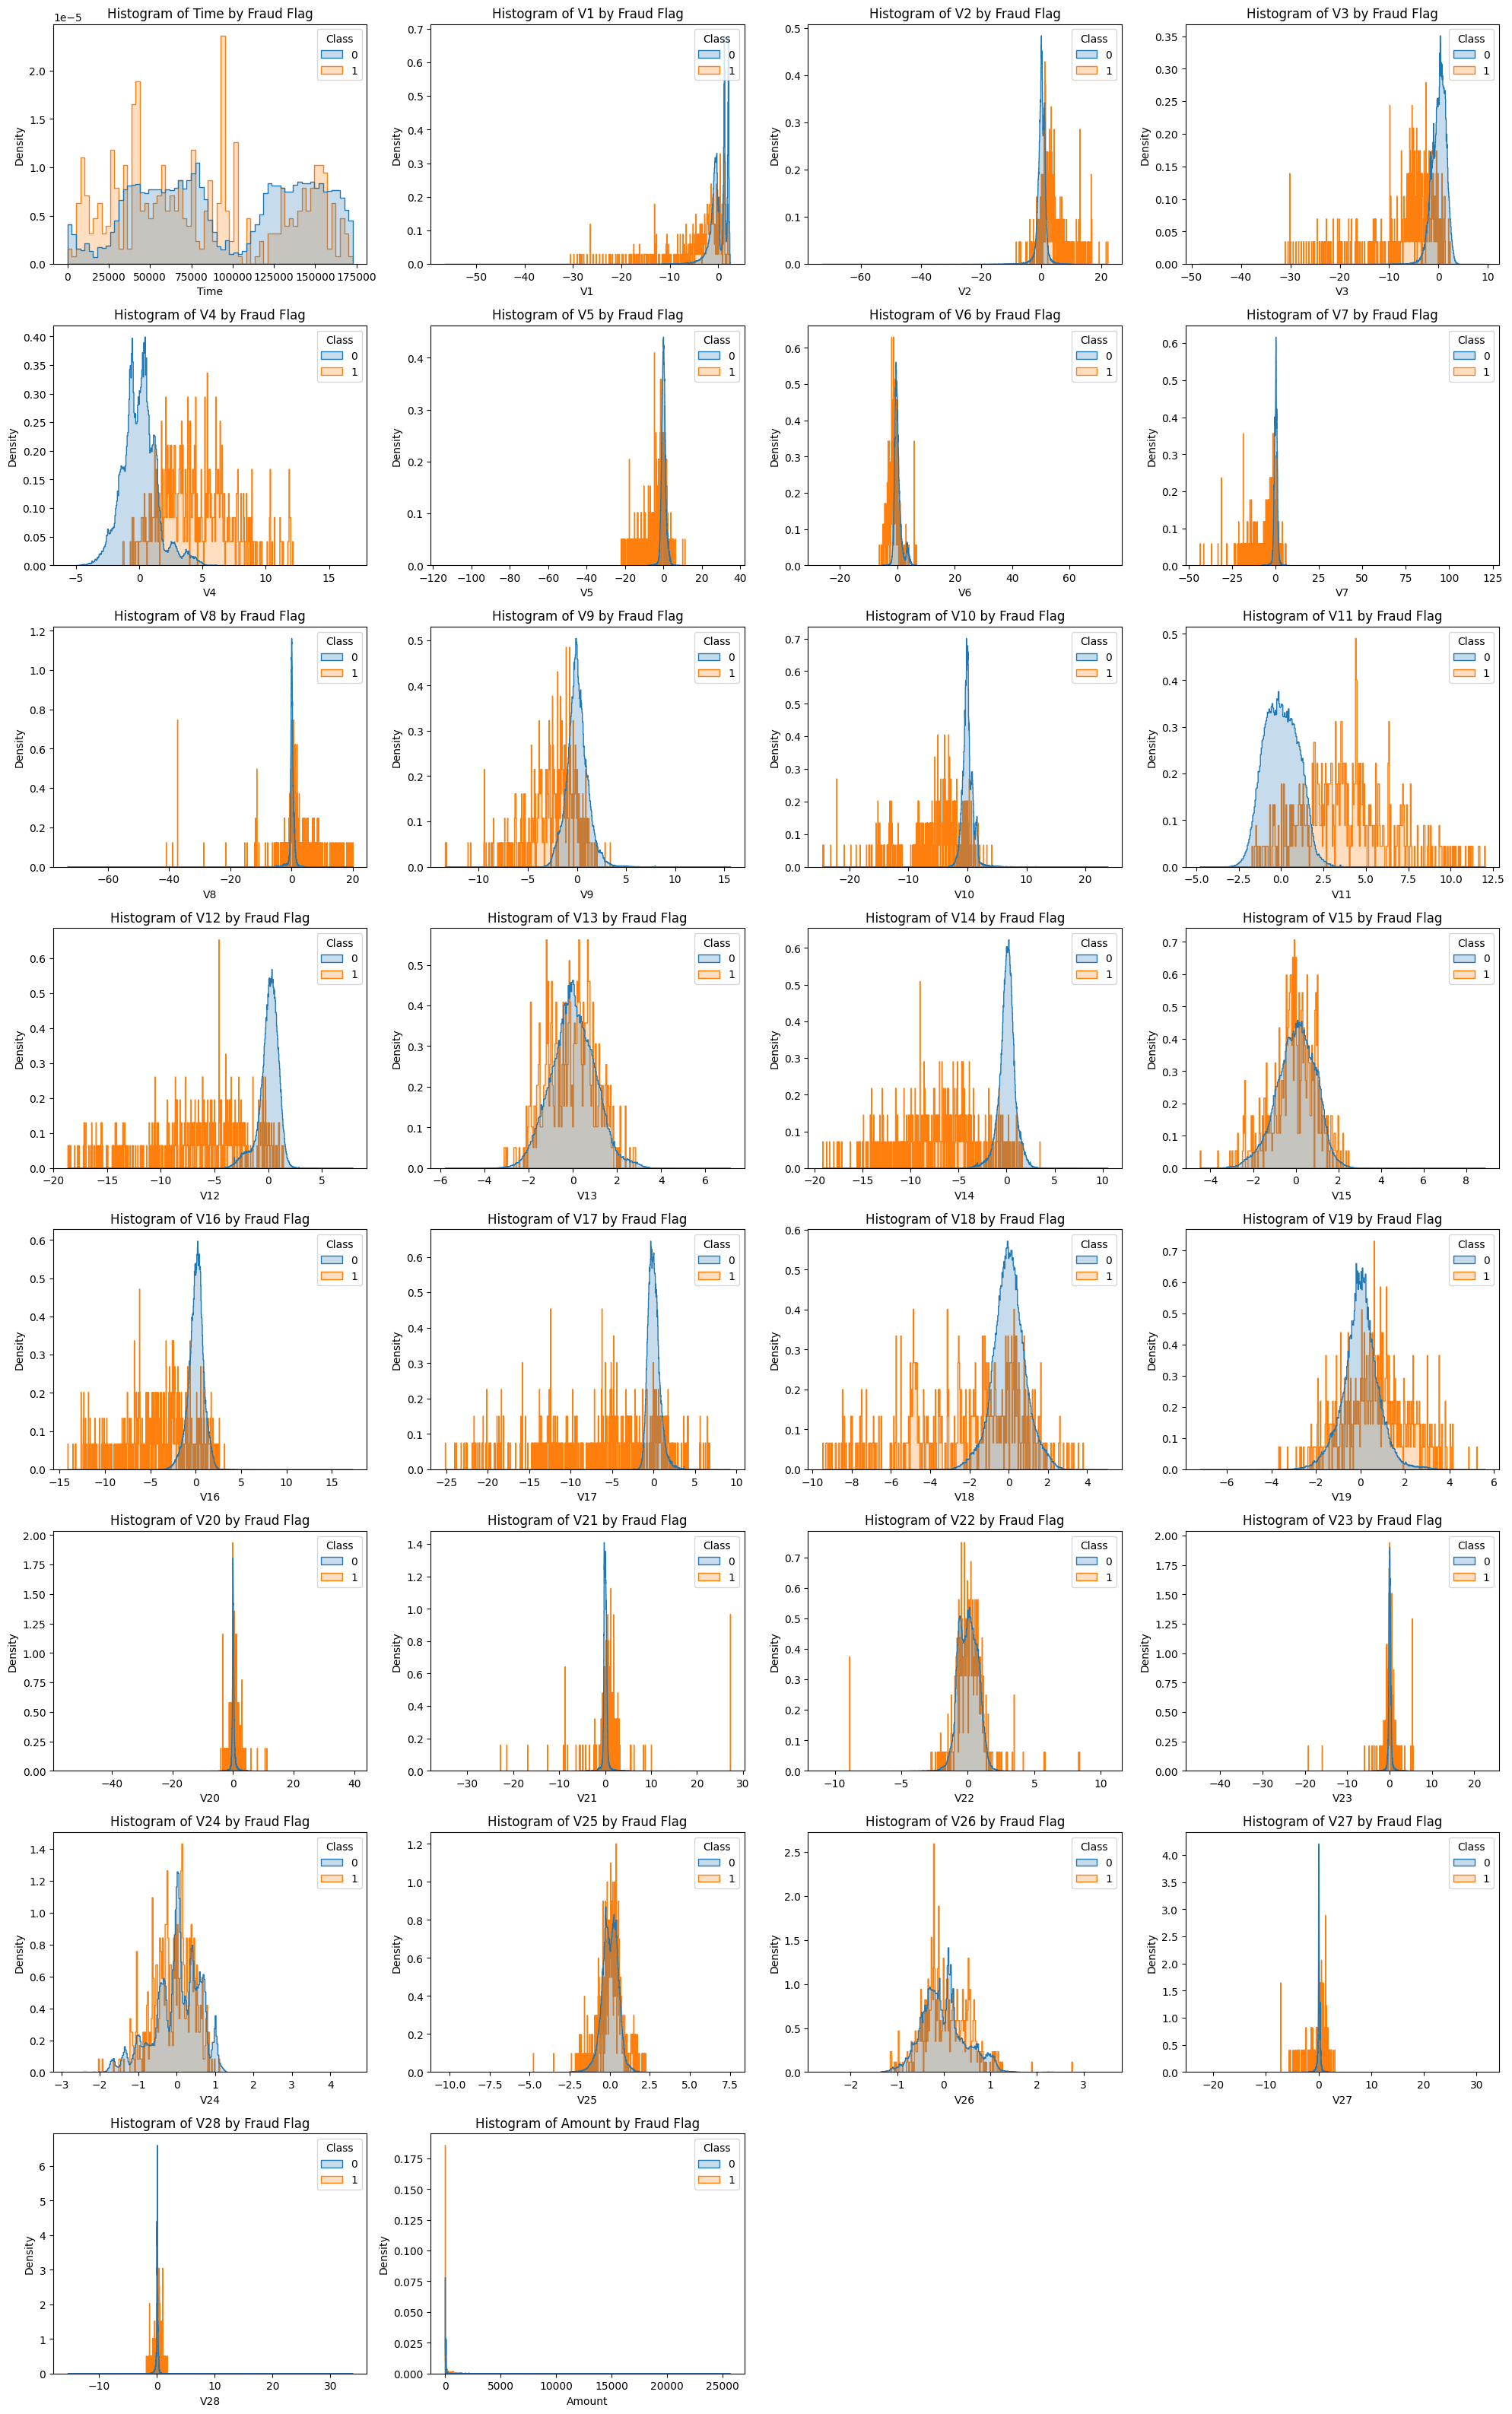

In [102]:
columns = df.drop('Class', axis=1).columns 
num_cols = len(columns)
n_cols_per_row = 4  # Number of subplots per row
n_rows = (num_cols + n_cols_per_row - 1) // n_cols_per_row  # Calculate the required number of rows

# Create a figure with subplots
f, axes = plt.subplots(nrows=n_rows, ncols=n_cols_per_row, figsize=(20, n_rows * 4))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Create histograms
for i, col in enumerate(columns):
    sns.histplot(df, x=col, hue="Class", element="step", ax=axes[i], stat="density", common_norm=False)
    axes[i].set_title(f'Histogram of {col} by Fraud Flag')

# Remove empty subplots
for i in range(len(columns), len(axes)):
    f.delaxes(axes[i])

plt.tight_layout()
plt.show()


# Resampling_methods
Time to choose resampling_method

In [106]:
X = df.drop(['Class'], axis=1)
y = df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

sampling_strategy = 0.03
new_threshold = 0.5

resampling_methods = {
    "SMOTE": SMOTE(sampling_strategy=sampling_strategy, random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=42),
    "ADASYN": ADASYN(sampling_strategy=sampling_strategy, random_state=42),
    "RandomOverSampler": RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42),
    "RandomUnderSampler": RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42),
    "SMOTEENN": SMOTEENN(sampling_strategy=sampling_strategy, random_state=42),
    "SMOTETomek": SMOTETomek(sampling_strategy=sampling_strategy, random_state=42)
}

# Store the results
results = {method: [] for method in resampling_methods.keys()}

# Loop over each resampling method
for name, method in resampling_methods.items():
        
    X_train_resampled, y_train_resampled = method.fit_resample(X_train, y_train)
    model = LGBMClassifier(verbose=-1)
    model.fit(X_train_resampled, y_train_resampled)
        
    # Make predictions and adjust them using the new threshold
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_adjusted = (y_pred_proba >= new_threshold).astype(int)

    # Calculate Precision-Recall and AUC for the adjusted predictions
    precision, recall, _ = precision_recall_curve(y_test, y_pred_adjusted)
    pr_auc = auc(recall, precision)

    # Store PR AUC for this iteration
    results[name].append(pr_auc)

# Calculate mean and standard deviation of PR AUC for each method
for method, pr_aucs in results.items():
    mean_pr_auc = np.mean(pr_aucs)
    print(f"\nMethod: {method}")
    print(f"PR AUC: {mean_pr_auc:.4f}")

# Identify the best method based on the highest mean PR AUC
best_method = max(results, key=lambda x: np.mean(results[x]))
print(f"\nBest Resampling Method: {best_method}")


{'SMOTE': [0.8070199708960581], 'BorderlineSMOTE': [0.8572509908474444], 'ADASYN': [0.8028376053340691], 'RandomOverSampler': [0.8746880110020263], 'RandomUnderSampler': [0.7850272499710699], 'SMOTEENN': [0.8680142573793389], 'SMOTETomek': [0.8442655922407795]}
--------------------------------------------------

Method: SMOTE
PR AUC: 0.8070

Method: BorderlineSMOTE
PR AUC: 0.8573

Method: ADASYN
PR AUC: 0.8028

Method: RandomOverSampler
PR AUC: 0.8747

Method: RandomUnderSampler
PR AUC: 0.7850

Method: SMOTEENN
PR AUC: 0.8680

Method: SMOTETomek
PR AUC: 0.8443

Best Resampling Method: RandomOverSampler


# Winner - RandomOverSampler
PR AUC: 0.8747

# With randomoversamlper let's take a look how different models take action on our dataset. Later on, we will choose one and find hyperparameters.

In [ ]:
def evaluate_model_with_threshold(model, X_test, y_test, threshold):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= new_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0) 
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    print("Confusion Matrix:\n", conf_matrix)
    print("Accuracy:", accuracy)
    print("ROC AUC Score:", roc_auc)
    print("Precision-Recall AUC:", pr_auc)
    print("Classification Report:\n", report)

X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

sampling_strategy = 0.03 # 0.16 from pr chart
new_threshold = 0.1

resampling_method = RandomOverSampler(sampling_strategy = sampling_strategy)

X_train_smote, y_train_smote = resampling_method.fit_resample(X_train, y_train)

# Define models
models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'SVC': SVC(probability=True),
    'SVC_Poly': SVC(kernel='poly', probability=True),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'XGBClassifier': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'CatBoostClassifier': CatBoostClassifier(verbose=0),
    'LGBMClassifier': LGBMClassifier(),
}

# Train and Evaluate each model with custom threshold
for model_name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    print(f"Evaluating {model_name} with threshold {new_threshold}")
    evaluate_model_with_threshold(model, X_test, y_test, threshold=new_threshold)

Evaluating RandomForestClassifier with threshold 0.1
Confusion Matrix:
 [[56827    37]
 [   11    87]]
Accuracy: 0.9991573329588147
ROC AUC Score: 0.9576410562114548
Precision-Recall AUC: 0.8882753155238705
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.89      0.78        98

    accuracy                           1.00     56962
   macro avg       0.85      0.94      0.89     56962
weighted avg       1.00      1.00      1.00     56962



# LightGBM + BayesSearch
CatBoostClassifier, XGB and LightGBM showing good results, so I will choose LightGBM for future analysis(because of speed ability)

Now we will proceed to search for the hyperparameters of our model.

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

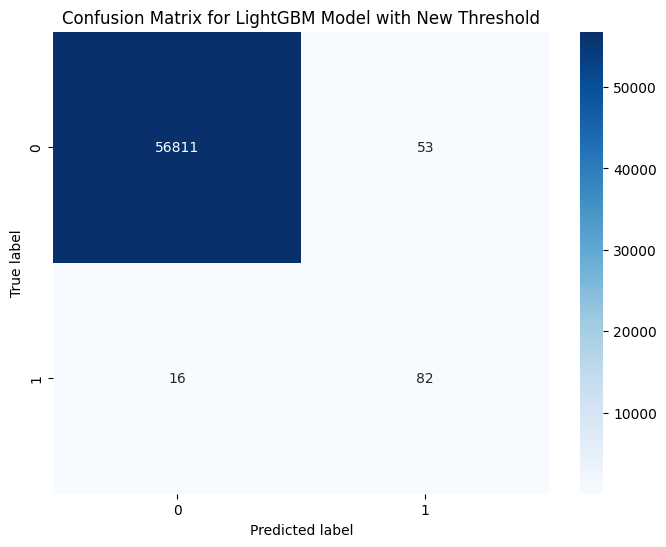

In [36]:
X = df.drop(['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
 
sampling_strategy = 0.16
new_threshold = 0.1
resampling_method = RandomOverSampler(sampling_strategy=sampling_strategy)
X_train_resampled, y_train_resampled = resampling_method.fit_resample(X_train, y_train)

# Define the search space for hyperparameters
search_spaces = {
    'num_leaves': Integer(31, 150),
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 12),
    'min_child_weight': Integer(1, 10),
    'subsample': Real(0.6, 0.9),
    'colsample_bytree': Real(0.6, 0.9),
    'reg_lambda': Real(0.0, 1.0),
    'scale_pos_weight': Real(1, 10)
}

np.int = int # This line solves problem with skop - np.int problem

bayes_search = BayesSearchCV(
    estimator=LGBMClassifier(verbose=-1),
    search_spaces=search_spaces,
    scoring='accuracy',
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the Bayesian search
bayes_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_model = bayes_search.best_estimator_

# Predictions with new threshold
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= new_threshold).astype(int)

# Evaluation with the new threshold
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the results
print("Best Hyperparameters:", bayes_search.best_params_)
print("Using New Threshold:", new_threshold)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Compute and plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for LightGBM Model with New Threshold')
plt.show()


# Apply hiperparameters and search for sampling_strategy and threshold

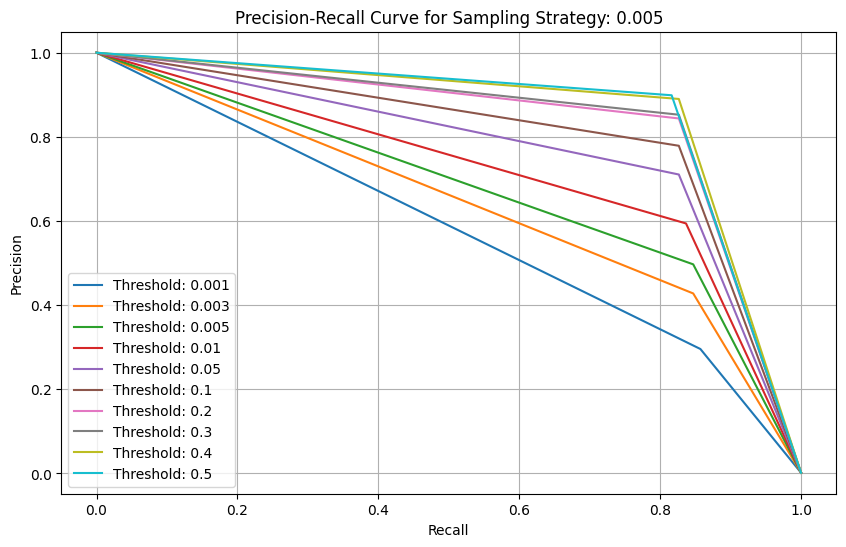

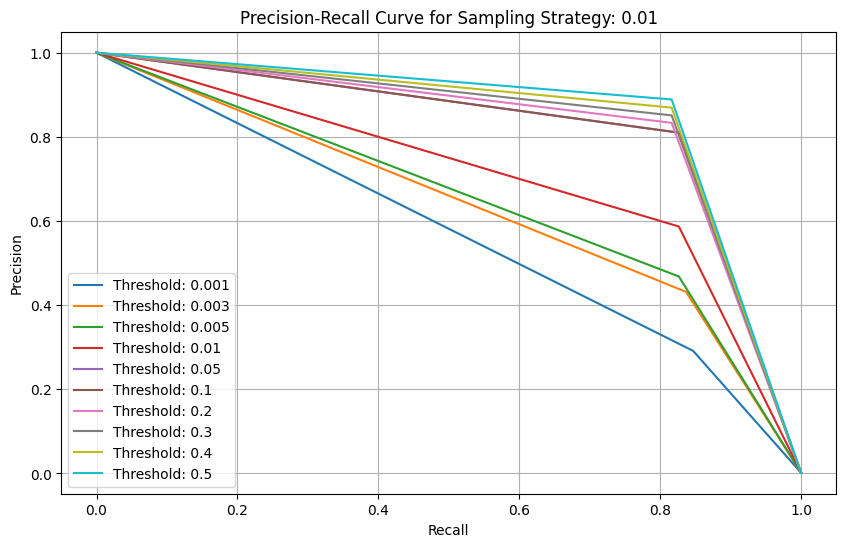

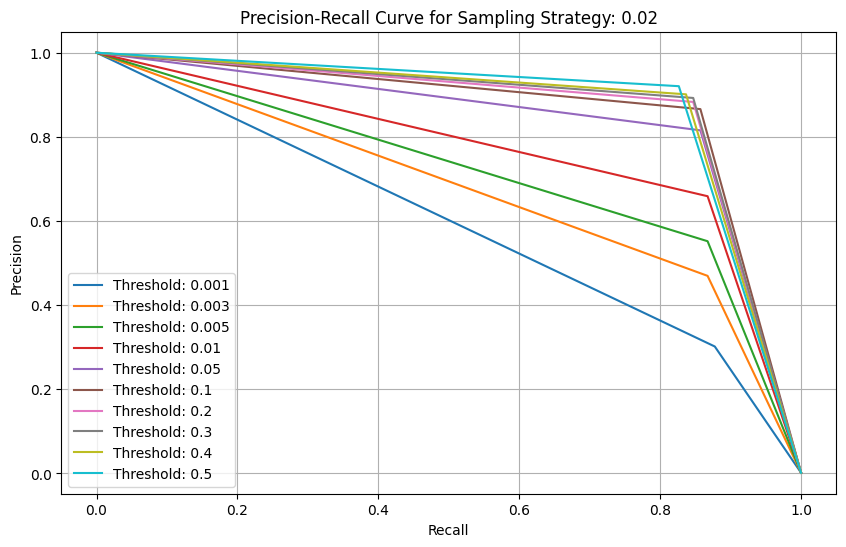

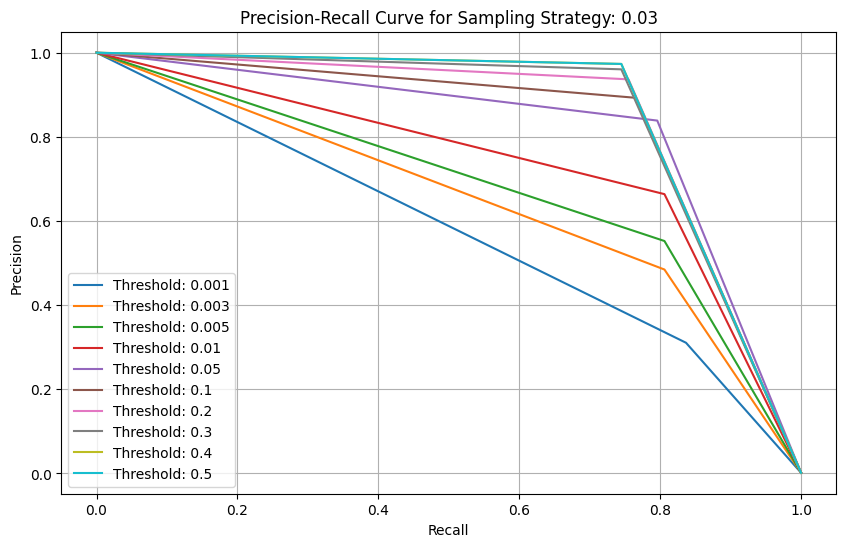

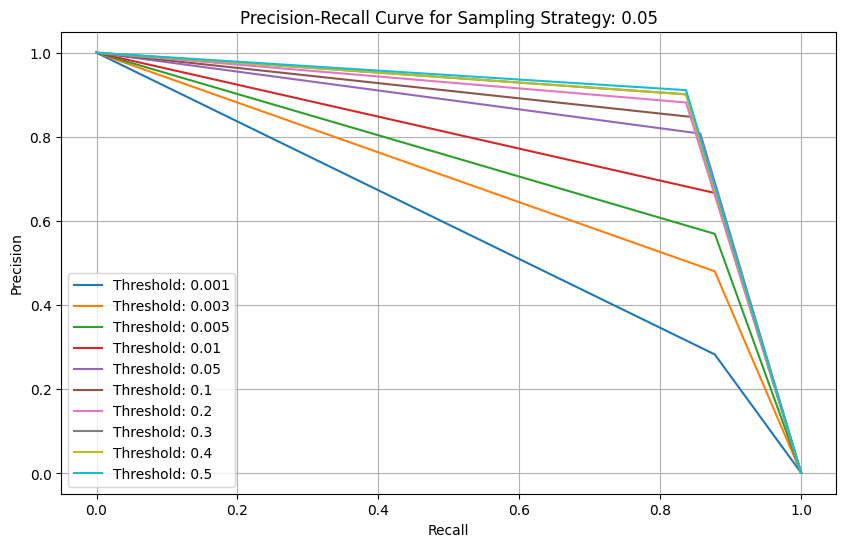

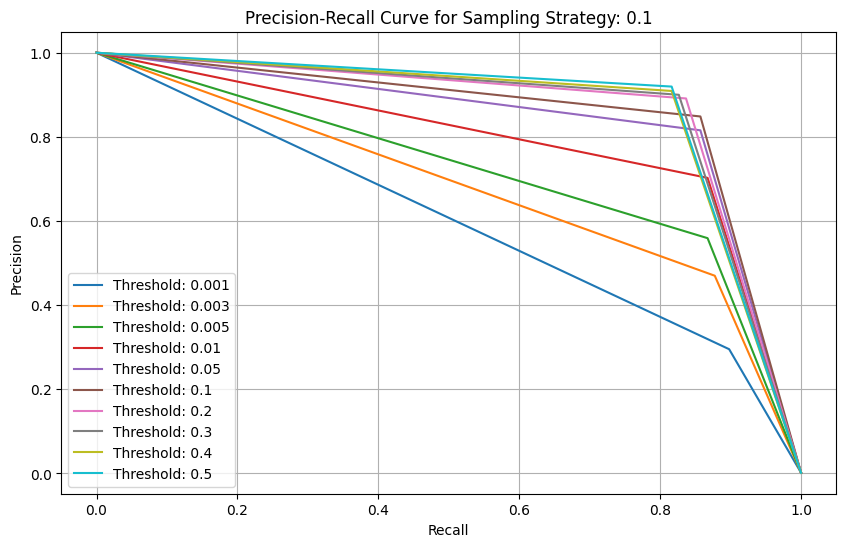

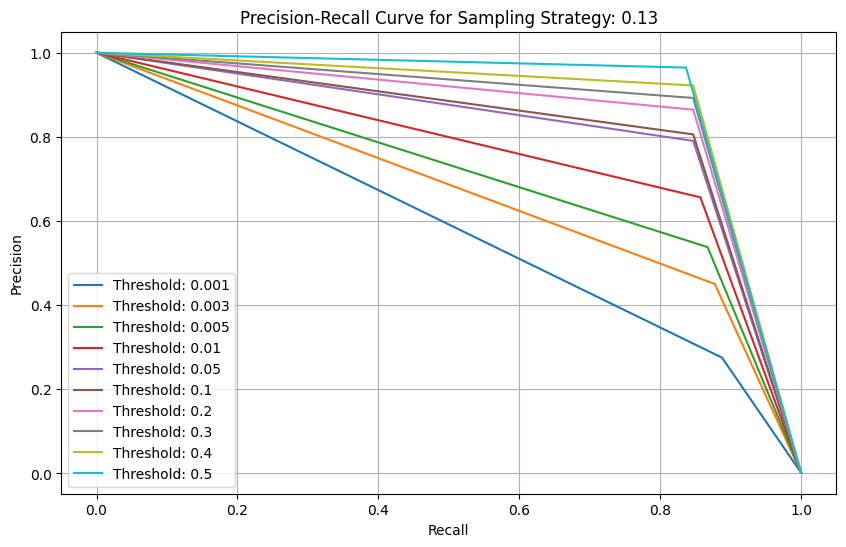

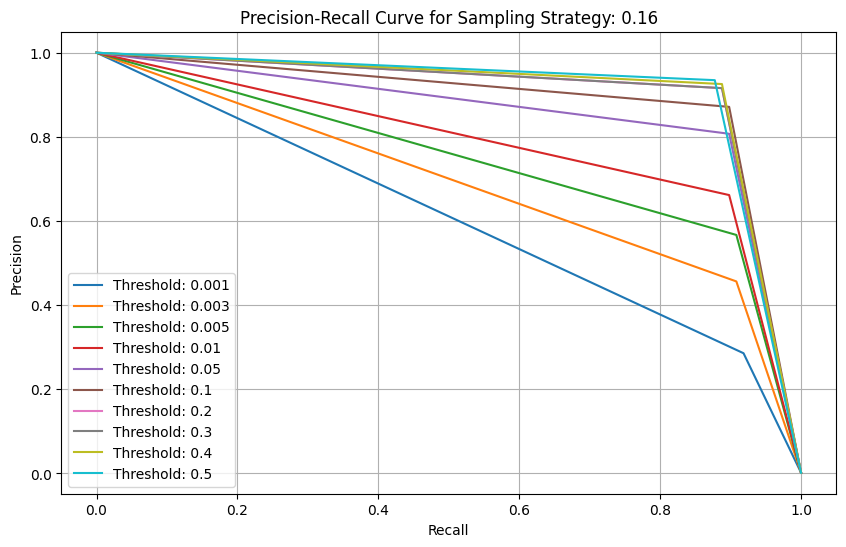

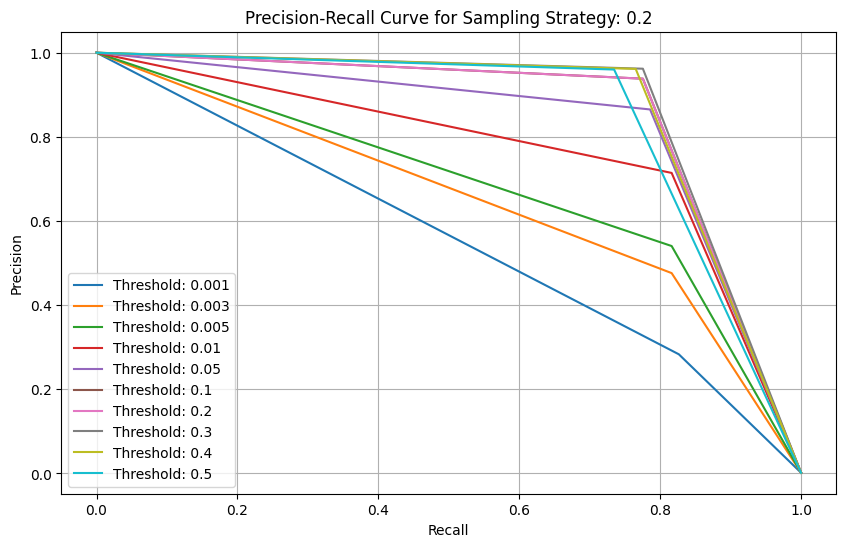

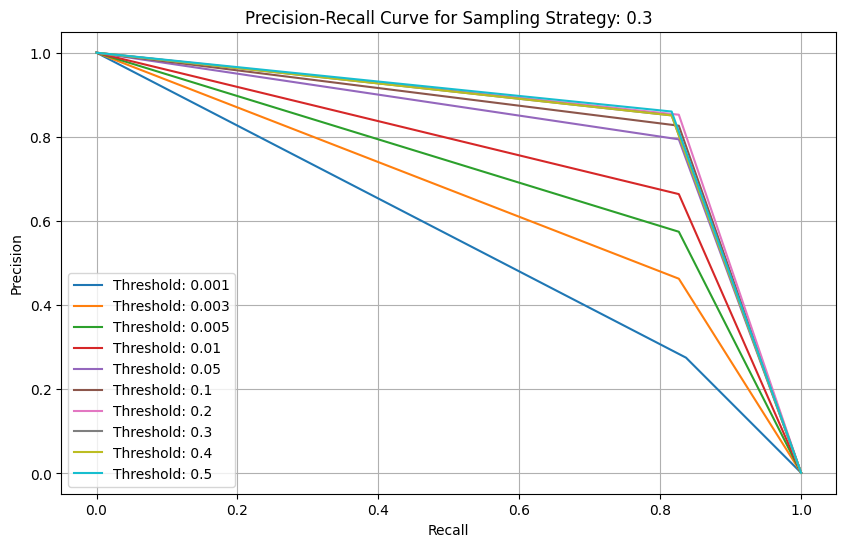

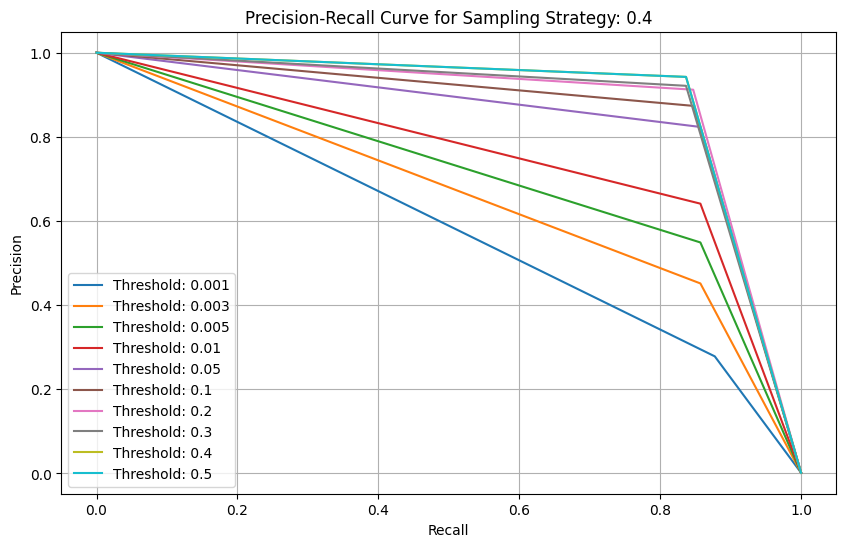

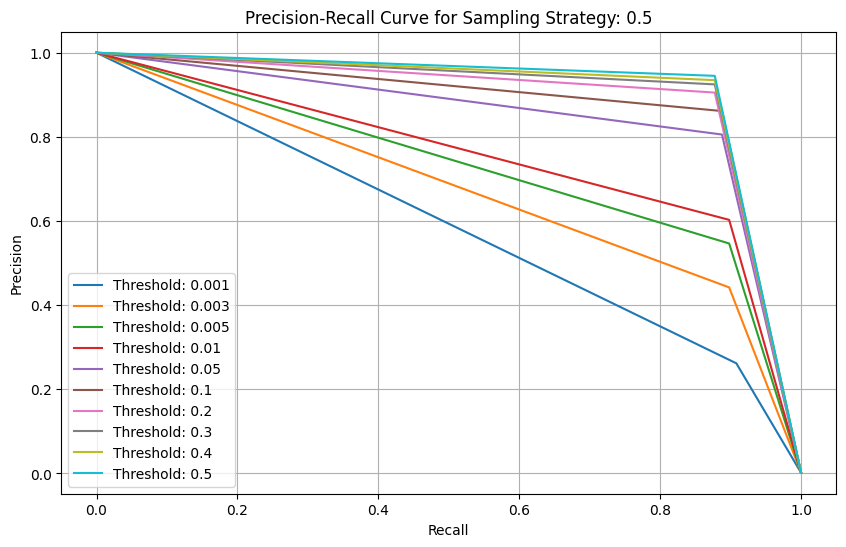

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier

X = df.drop(['Class'], axis=1)
y = df['Class']

# Define parameters for loop to detect the best recall and precision
sampling_strategies = [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.13, 0.16, 0.2, 0.3, 0.4, 0.5]  
thresholds = [0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# Define the best hyperparameters
best_params = {
    'colsample_bytree': 0.9,
    'learning_rate': 0.1034595680631685,
    'max_depth': 12,
    'min_child_weight': 1,
    'n_estimators': 178,
    'num_leaves': 132,
    'reg_lambda': 0.3587852910800582,
    'subsample': 0.9,
    'scale_pos_weight': 8.847706193358363
}

# Loop over different sampling_strategy values
for sampling_strategy in sampling_strategies:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    # Apply resampling
    resampling_method = RandomOverSampler(sampling_strategy=sampling_strategy)
    X_train_resampled, y_train_resampled = resampling_method.fit_resample(X_train, y_train)

    # Train the model with best hyperparameters
    model = LGBMClassifier(verbose=-1, **best_params)
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Plotting the precision-recall curve for different thresholds
    plt.figure(figsize=(10, 6))

    for thresh in thresholds:
        # Adjust predictions based on the current threshold
        y_pred_adjusted = (y_pred_proba >= thresh).astype(int)
        
        # Calculate precision and recall for the current threshold
        precision, recall, _ = precision_recall_curve(y_test, y_pred_adjusted)
        
        # Plot the precision-recall curve
        plt.plot(recall, precision, label=f'Threshold: {thresh}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Sampling Strategy: {sampling_strategy}')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()


# Apply threshold and sampling_strategy to LGBM

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.87      0.87        98

    accuracy                           1.00     56962
   macro avg       0.94      0.93      0.94     56962
weighted avg       1.00      1.00      1.00     56962



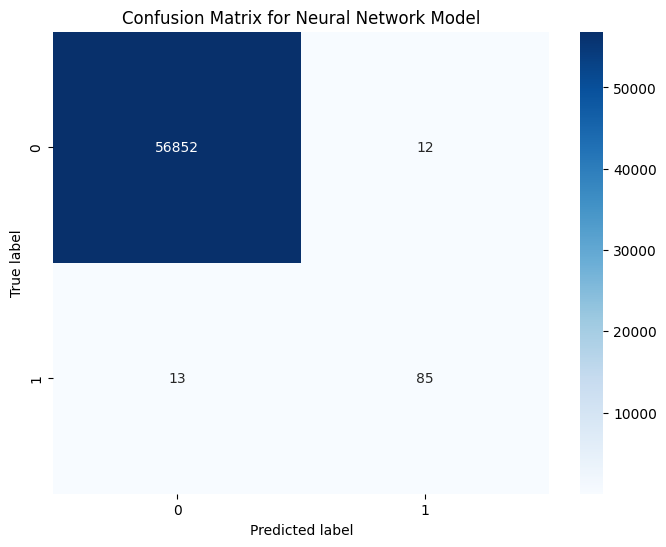

In [54]:
X = df.drop(['Class'], axis=1)
y = df['Class']

# Define parameters
sampling_strategy = 0.16
new_threshold = 0.1

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Apply resampling
resampling_method = RandomOverSampler(sampling_strategy=sampling_strategy)
X_train_resampled, y_train_resampled = resampling_method.fit_resample(X_train, y_train)

# Define the best hyperparameters
best_params = {
    'colsample_bytree': 0.9,
    'learning_rate': 0.1034595680631685,
    'max_depth': 12,
    'min_child_weight': 1,
    'n_estimators': 178,
    'num_leaves': 132,
    'reg_lambda': 0.3587852910800582,
    'subsample': 0.9,
    'scale_pos_weight': 8.847706193358363
}

# Train the model with best hyperparameters
model = LGBMClassifier(verbose=-1, **best_params)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_adjusted = (y_pred_proba >= new_threshold).astype(int)

# Evaluate the model
report = classification_report(y_test, y_pred_adjusted)
print(classification_report(y_test, y_pred_adjusted, zero_division=0))

# Compute and plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Neural Network Model')
plt.show()


# Neural network
with early stopping focused on validation set.

Epoch 1/20
8918/8918 [==============================] - 18s 2ms/step - loss: 0.0233 - accuracy: 0.9932 - val_loss: 0.0075 - val_accuracy: 0.9983
Epoch 2/20
8918/8918 [==============================] - 15s 2ms/step - loss: 0.0067 - accuracy: 0.9984 - val_loss: 0.0070 - val_accuracy: 0.9988
Epoch 3/20
8918/8918 [==============================] - 16s 2ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0060 - val_accuracy: 0.9988
Epoch 4/20
8918/8918 [==============================] - 16s 2ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.0078 - val_accuracy: 0.9984
Epoch 5/20
8918/8918 [==============================] - 16s 2ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0072 - val_accuracy: 0.9990
Epoch 6/20
8918/8918 [==============================] - 16s 2ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0055 - val_accuracy: 0.9991
Epoch 7/20
8918/8918 [==============================] - 16s 2ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0075 - val_ac

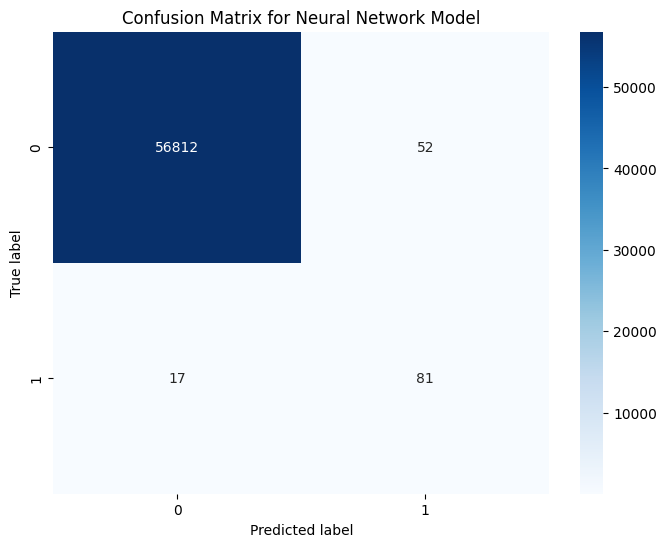

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# Adjusting parameters
sampling_strategy = 0.16
epochs = 20
threshold = 0.1
metrics = ['accuracy'] 

# Assuming df is your DataFrame
X = df.drop(['Class'], axis=1)
y = df['Class']

# Train-test split
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, stratify=y_train_temp) 

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply oversampling
resampling_method = RandomOverSampler(sampling_strategy=sampling_strategy)
X_train_resampled, y_train_resampled = resampling_method.fit_resample(X_train_scaled, y_train)

# Neural Network Model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=6,      
    restore_best_weights=True  
)

# Model Training with Early Stopping and Validation Set

history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_val_scaled, y_val),
    epochs=epochs,
    batch_size=22,
    callbacks=[early_stopping]
)

# Prediction
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > threshold).astype(int)

# Compute the metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the classification report and confusion matrix
print(classification_report(y_test, y_pred, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print the individual metrics
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Compute and plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Neural Network Model')
plt.show()
